# run with run_rosetta_notebook.bash !!!

### prepare ligands with molfile_to_paprams.py
#### you may need to first run: "export PYTHONPATH=/home/domain/anur/distr/rosetta_2015_02/rosetta_src_2015.02.57538_bundle/main/source/src/python/" 

In [4]:
import sys
import os
import operator as op
import itertools
import matplotlib as mpl
import re
#os.environ['LD_LIBRARY_PATH']+=':/home/anur/PyRosetta.monolith.ubuntu.release-93/'



#sys.path.append('/home/anur/PyRosetta.monolith.ubuntu.release-93/')
sys.path.append('/home/domain/data/prog/pyrosetta/')

from rosetta import *
from toolbox import *
from rosetta.utility import vector1_bool
init() 

import numpy as np
%matplotlib inline
import seaborn as sns

from matplotlib import pyplot as plt
import pandas
from  numpy.random import randint

from joblib import Parallel, delayed

from collections import Counter  # for counting subs in best mutant report generation


PYROSETTA_DATABASE environment variable was set to: /home/domain/data/prog/pyrosetta/rosetta_database; using it....
PyRosetta 3.4.0 [Rosetta-3.4 55980:55980:fc2b8dc1c719421d421c7a90f3e684ca0c1d0609] retrieved from: 
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Rosetta version  from
core.init: command: PyRosetta -ex1 -ex2aro -database /home/domain/data/prog/pyrosetta/rosetta_database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=348640445 seed_offset=0 real_seed=348640445
core.init.random: RandomGenerator:init: Normal mode, seed=348640445 RG_type=mt19937


let use pymol for visual anlisys and debuging

In [5]:
 #pymover = PyMOL_Mover() 
os.environ['LD_LIBRARY_PATH']
def aaa2a(aa):
    d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    return d[aa]
def generate_nonstandard_residue_set(params_list):

    res_set  = ChemicalManager.get_instance().nonconst_residue_type_set('fa_standard')
    atoms    = ChemicalManager.get_instance().atom_type_set('fa_standard')
    mm_atoms = ChemicalManager.get_instance().mm_atom_type_set('fa_standard')
    orbitals = ChemicalManager.get_instance().orbital_type_set('fa_standard')
    elements = ChemicalManager.get_instance().element_set('fa_standard')
        
    res_set.read_files(params_list, atoms, elements, mm_atoms, orbitals)

    return res_set

# THE GREAT WALL OF CHINA

In [ ]:
todo:
    more rotameres
    less aminoacid choices
    min mover
    bb mover?
    get it to work with Fv fragment

general logic:

try for  single, double and triple mutants

for each contacting residue:
1) mutate a residue contacting the ligand 
2) repack all residues in vicinity without mutating 
3) calculate energy
4) mutate again and compare


In [4]:
def create_mutant(pose_m, pack_radius, mutations, fixed):
    
    mut_res = [m[0] for m in mutations]
    mut_aa = [m[1] for m in mutations]
    
    pose = Pose()
    pose.assign(pose_m)
    task = standard_packer_task(pose)
   
    center = pose.residue(fixed[0]).xyz("P")
    
    scorefxn = create_score_function("talaris2013_cst")
    packer = PackRotamersMover(scorefxn, task)
   # packer = RotamerTrialsMinMover(scorefxn, task) #  "It is the only mover capable of going off-rotamer in search of low-energy side-chain conformations" - Manual ### extremely slow >> 5 min
    
    mm=MoveMap()
    mm.set_bb(False)
    mm.set_chi(False)

    scorefxn2 = create_score_function("ligand")
    minmover = MinMover(mm, scorefxn2, 'dfpmin', 0.002, True) 



    # first modify task to prevent undesirable mutations
    # we iterate over all residues NOT in "index" and NOT in range
    # and prevent repacking
    
    for i in range(1, pose.total_residue() + 1):
        if center.distance_squared(pose.residue(i).nbr_atom_xyz() ) > pack_radius**2 or i in fixed:
            task.nonconst_residue_task(i).prevent_repacking()    
        if center.distance_squared(pose.residue(i).nbr_atom_xyz() ) <= pack_radius**2 and i not in fixed and i not in mut_res: 
            task.temporarily_set_pack_residue(i, True)
            task.nonconst_residue_task(i).restrict_to_repacking() 
            mm.set_chi(i,True)  # minimize only residues in range
            

        elif i in mut_res:
            task.temporarily_set_pack_residue(i, True)
            mut_bool = vector1_bool()
            new_aa = aa_from_oneletter_code(mut_aa.pop(0))
            for r in range( 1 , 21 ):
                mut_bool.append( r == new_aa )
            task.nonconst_residue_task(i).restrict_absent_canonical_aas(mut_bool) # restrict mutations
            mm.set_chi(i,True)
                
    # apply the pose

    packer.apply(pose)
    pose.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" +"before_em_" + "".join(["".join([str(z) for z in s]) for s in mutations]) + ".pdb")
    print "total energy before: " + str([pose.energies().residue_total_energies(x).sum() for x in fixed]) + "  pose energy " + str(scorefxn(pose))
    # minimize energy
    minmover.apply(pose)


    pose.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" +"after_em_" + "".join(["".join([str(z) for z in s]) for s in mutations]) + ".pdb")
    print "total energy after: " + str([pose.energies().residue_total_energies(x).sum() for x in fixed]) + "  pose energy " + str(scorefxn(pose))
#    print task

# now try bb
    for i in range(1, pose.total_residue() + 1):
            if center.distance_squared(pose.residue(i).nbr_atom_xyz() ) <= pack_radius**2 and i not in fixed and i not in mut_res: 
                mm.set_bb(i,True)  # 
    
    pose.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" +"after_bb_" + "".join(["".join([str(z) for z in s]) for s in mutations]) + ".pdb")
    print "total energy after: " + str([pose.energies().residue_total_energies(x).sum() for x in fixed]) + "  pose energy " + str(scorefxn(pose))          
                
    name = "/home/domain/data/kirill/AB/XOP/rosetta/outs/" + "".join(["".join([str(z) for z in s]) for s in mutations]) + ".dat"
    f = open(name, "w")
    f.write("".join(["".join([str(z) for z in s]) for s in mutations])+"\t"+"\t".join([str(pose.energies().residue_total_energies(x).sum()) for x in fixed]))
    f.close()
    return [mutations,[pose.energies().residue_total_energies(x).sum() for x in fixed],scorefxn(pose)]

In [5]:
# run once!
ligand_params = Vector1(['/home/domain/data/kirill/AB/XOP/prepare_ligs/XOPR.params'])
new_res_set = generate_nonstandard_residue_set(ligand_params)

core.chemical.ResidueTypeSet: Finished initializing fa_standard residue type set.  Created 9282 residue types


In [6]:
pose_m = pose_from_pdb(new_res_set, '/home/domain/data/kirill/AB/XOP/rosetta/relaxed.pdb')

core.conformation.Conformation: Found disulfide between residues 21 96
core.conformation.Conformation: current variant for 21 CYS
core.conformation.Conformation: current variant for 96 CYS
core.conformation.Conformation: current variant for 21 CYD
core.conformation.Conformation: current variant for 96 CYD
core.conformation.Conformation: Found disulfide between residues 137 204
core.conformation.Conformation: current variant for 137 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 137 CYD
core.conformation.Conformation: current variant for 204 CYD
core.pack.task: Packer task: initialize from command line()


In [7]:
reactive = []
for a in range(1, pose_m.total_residue()+1):
    if pose_m.residue(a).name() == "XOP": reactive.append(a)
center = pose_m.residue(reactive[0]).xyz("P")
reactive.append(148)

In [ ]:
print reactive

In [ ]:
res = pose_m.residue(34)

In [ ]:
zzz=res.nbr_atom_xyz()

In [ ]:
zzz.x,zzz.y,zzz.z

In [ ]:
print res

In [ ]:

# identify mutants positions (contacts with ligand )
# basically limit the number of residues we consider by 20 + 2 fixed

pack_radius = 117**0.5 # A^2
# fix the reactive tyrosine and the ligand
fixed = reactive # [433, 248]
number_of_mutations = 2

residues = ["G","A","L","I","S","T","F","Y","W","D","E","Q","N","V","M","R","K","H"] # "C","P"

positions = []
center = pose_m.residue(fixed[0]).xyz("P")
for i in range(1, pose_m.total_residue() + 1):
    if center.distance_squared(pose_m.residue(i).nbr_atom_xyz()) < pack_radius**2 and i not in fixed:
        positions.append(i)

# generate a list of triple mutations
mutation_pos = itertools.combinations(positions,number_of_mutations)
mutation_res = itertools.product(residues, repeat=number_of_mutations)
mutations = []
for r in itertools.product(mutation_pos, mutation_res):
    mutations.append(zip(r[0],r[1]))
print len(mutations)

In [ ]:
test_muts = mutations[:20] + [[(34, 'Y')]]
print test_muts

In [ ]:
energies = []
ref = [133.1970932959138, 152.48720505641305] # from 250 D 307 W mutation - without minmover
ref = [[133.47742047138792, 152.3116453812437], 464.26405159725823] # with minmover
for mutation in test_muts[:1]:
    print "doing " + str(mutations.index(mutation)) + str(mutation)
    energy = create_mutant(pose_m,pack_radius,mutation,fixed)
   # if energy[0] > ref[0] or energy[1] > ref[1]:     continue
    energies.append(energy)
    

In [ ]:
Parallel(n_jobs=4)(delayed(create_mutant)(pose_m,pack_radius,mutation,fixed) for mutation in test_muts)

In [ ]:
ens = [e[2] for e in energies]
ens2 = [e[1] for e in energies]
#plt.plot(ens)
plt.plot(ens2)
print  [e[0] for e in energies]

In [ ]:
out = Parallel(n_jobs=4)(delayed(create_mutant)(pose_m,pack_radius,mutation,fixed) for mutation in mutations[:16])

# PLOTTING 

In [ ]:
en = [(e[1][0] - 133.197, e[1][1] - 152.487) for e in out if e[1][0] < 133.197 and e[1][1] < 152.487]


plt.scatter([e[0] for e in en], [e[1] for e in en])
plt.title("Double mutant ligand energy") 
plt.xlabel("N")
plt.ylabel("energy")

In [ ]:
all_en = [sum(e[1]) for e in out]
en2 = sorted(all_en)
en_best = [all_en.index(z) for z in en2[:10]]
best_mut = [out[z] for z in en_best]

In [ ]:
print best_mut

In [ ]:
for mut in best_mut:
    mutation = mut[0]
    print create_mutant(pose_m,pack_radius,mutation,fixed)

# testing playground

In [ ]:
test_pose = Pose()
test_pose.assign(pose_m)
#test_pose.add_constraint()
task = standard_packer_task(test_pose)
scorefxn = create_score_function("talaris2013_cst")
packer = PackRotamersMover(scorefxn, task)
#packer =  RotamerTrialsMinMover(scorefxn, task) #  "It is the only mover capable of going off-rotamer in search of low-energy side-chain conformations" - Manual
    
    

In [ ]:
mutation = mutations[0]

In [ ]:
center = test_pose.residue(fixed[0]).xyz("P")
mut_res = [m[0] for m in mutation]
mut_aa = [m[1] for m in mutation]

o = []

for i in range(1, test_pose.total_residue() + 1):
        if center.distance_squared(test_pose.residue(i).nbr_atom_xyz() ) > pack_radius**2 or i in fixed:
            
            task.nonconst_residue_task(i).prevent_repacking()    
        if center.distance_squared(test_pose.residue(i).nbr_atom_xyz() ) <= pack_radius**2 and i not in fixed and i not in mut_res: 
            task.temporarily_set_pack_residue(i, True)
            task.nonconst_residue_task(i).restrict_to_repacking() 
          #  mm.set_chi(i,True)  # minimize only residues in range
            o.append(i)
        elif i in mut_res:
            o.append(i)
            task.temporarily_set_pack_residue(i, True)
            mut_bool = vector1_bool()
            new_aa = aa_from_oneletter_code(mut_aa.pop(0))
            for r in range( 1 , 21 ):
                mut_bool.append( r == new_aa )
            task.nonconst_residue_task(i).restrict_absent_canonical_aas(mut_bool) # restrict mutations
         #   mm.set_chi(i,True)

In [ ]:
mm=MoveMap()
mm.set_bb(False)
mm.set_chi(False)

scorefxn2 = create_score_function("ligand")
minmover = MinMover(mm, scorefxn2, 'dfpmin', 0.01, True) 

In [ ]:
print minmover

In [ ]:
test_pose = Pose()
test_pose.assign(pose_m) 
center = test_pose.residue(fixed[0]).xyz("P")
for i in range(1, test_pose.total_residue() + 1):
    if center.distance_squared(test_pose.residue(i).nbr_atom_xyz()) < pack_radius**2 and i not in fixed:
        mm.set_chi(i,True)
test_pose.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" +"test_minmover_before.pdb")
print scorefxn(test_pose)
minmover.apply(test_pose)
test_pose.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" +"test_minmover_after.pdb")


print scorefxn(test_pose)

In [ ]:
[aa_from_oneletter_code("Y") == i for i in range(1,21)]

In [ ]:
pose_m.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/before_" + aa + ".pdb")
packer = PackRotamersMover(scorefxn, task)
packer.apply(pose_m)

pose_m.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" + aa + ".pdb")

In [ ]:
mutate_residue(pose_m, 248, "A")
pose_m.dump_pdb("/home/domain/data/kirill/AB/XOP/rosetta/" + "248A" + ".pdb")

In [ ]:
prin asd

# selecting residues for substitution

In [29]:
print pdb
print i
print pose_m.residue(223).nbr_atom_xyz().x

a5RY33Lprf0_3-fixed.pdb
225
56.845


In [11]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/backrub_input_structures/")
pss = []
pack_radius = 117**0.5
positions_newpdb = []
for pdb in os.listdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/backrub_input_structures/"):

    if not pdb.endswith("-relaxed.pdb"): continue
    print pdb
    
    pose_m = pose_from_pdb(new_res_set, pdb)
    reactive = []
    for a in range(1, pose_m.total_residue()+1):
        if pose_m.residue(a).name() == "XOP": 
            reactive.append(a)
            reactive.append(148)
            
    center = pose_m.residue(reactive[0]).xyz("P")
    positions = []
    
    
    for i in range(1, pose_m.total_residue() + 1):
        if center.distance_squared(pose_m.residue(i).nbr_atom_xyz()) < pack_radius**2 and i not in reactive and i != 48 and i != 97:
            positions.append(pose_m.pdb_info().number(i))
            positions_newpdb.append(i)
    pss.append(pdb + " " + " ".join([str(a) for a in positions]))
    
    # generate a resfile
    lines = []   
    recs = {}
    lines.append("NATRO\n")
    lines.append("EX 1 EX 2\nstart\n")
    for position in positions:
        recs.update({position:" _ " + "ALLAAxc\n"})
    ls = [str(k) + recs[k] for k in sorted(recs.keys())]
    for l in ls:
        lines.append(l)
    lines.append(str(pose_m.pdb_info().number(reactive[0])) + " _ " + "NATRO\n")
    lines.append(str(pose_m.pdb_info().number(reactive[1])) + " _ " + "NATAA\n")
    f = open(pdb[:-4] + ".resfile","w")
    f.writelines(lines)
    f.close()
    lines = []


a5RY33Lprf0_4-relaxed.pdb
core.io.pdb.file_data: [ WARNING ] discarding 1 atoms at position 117 in file a5RY33Lprf0_4-relaxed.pdb. Best match rsd_type:  SER
core.io.pdb.file_data: [ WARNING ] discarding 3 atoms at position 118 in file a5RY33Lprf0_4-relaxed.pdb. Best match rsd_type:  VAL
core.io.pdb.file_data: [ WARNING ] discarding 1 atoms at position 224 in file a5RY33Lprf0_4-relaxed.pdb. Best match rsd_type:  LYS
core.io.pdb.file_data: Adding undetected upper terminus type to residue 224
core.conformation.Conformation: Found disulfide between residues 21 96
core.conformation.Conformation: current variant for 21 CYS
core.conformation.Conformation: current variant for 96 CYS
core.conformation.Conformation: current variant for 21 CYD
core.conformation.Conformation: current variant for 96 CYD
core.conformation.Conformation: Found disulfide between residues 137 204
core.conformation.Conformation: current variant for 137 CYS
core.conformation.Conformation: current variant for 204 CYS
core.

In [22]:
poss = set()
for p in pss:
    pp = p.split()
    pz = pp[1:]
    new_pz = []
    for px in pz:
        if int(px) > 118:
            px = "L" + str(int(px) - 115)
        else: px = "H" + str(int(px) + 0)
        new_pz.append(px)
    poss.update(new_pz)
    
print " ".join(sorted(poss)) # for xrd numbering 
print "+".join([v[1:] for v in poss if v[0]=="L"])     # a line for pymol visualization
print sorted(list(set(positions_newpdb)))

H100 H101 H102 H103 H105 H33 H34 H36 H51 H53 H59 H99 L100 L27 L31 L32 L34 L35 L47 L50 L51 L90 L91 L92 L93 L94 L97 L98 L99
50+51+47+27+94+97+90+91+92+93+98+99+100+34+35+32+31
[33, 34, 36, 51, 53, 59, 99, 100, 101, 102, 103, 105, 142, 146, 147, 149, 150, 162, 165, 166, 205, 206, 207, 208, 209, 212, 213, 214, 215]


In [14]:
len(set(positions_newpdb))

29

# backrub script resfile generation

In [ ]:
117**0.5 # A^2

In [ ]:

# identify mutants positions (contacts with ligand )
# basically limit the number of residues we consider by 20 + 2 fixed

pack_radius = 117**0.5 # A^2
# fix the reactive tyrosine and the ligand
fixed = reactive
number_of_mutations = 2

residues = ["G","A","L","I","S","T","F","Y","W","D","E","Q","N","V","M","R","K","H","P"] # ,"C"

positions_pose = []

center = pose_m.residue(fixed[0]).xyz("P")


for i in range(1, pose_m.total_residue() + 1):
    if center.distance_squared(pose_m.residue(i).nbr_atom_xyz()) < pack_radius**2 and i not in fixed:
        positions_pose.append(i) # pose numbering
        
positions_pdb = [pose_m.pdb_info().number(i) for i in positions_pose]


# generate a list of single mutations
mutation_pos = itertools.combinations(positions_pdb, number_of_mutations)
mutation_res = itertools.product(residues, repeat=number_of_mutations)
mutations = []
for r in itertools.product(mutation_pos, mutation_res):
    mutations.append(zip(r[0],r[1]))
print len(mutations)

In [ ]:
print mutations[0]
print positions_pose
print "+".join([str(i) for i in positions_pdb])

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/double_muts/")

In [ ]:
print zip(positions_pose, positions_pdb)


In [ ]:
# create resfile
lines = []
recs = {}
for mutation in mutations:    
    lines.append("NATRO\n")
    lines.append("EX 1 EX 2\nstart\n")
    for position in positions_pdb:
        recs.update({position:" _ " + "NATAA\n"}) # set to native aa as default
        for substitution in mutation:
            if position == substitution[0] and recs[position].split()[1] != "PIKAA":
                recs.update({position:" _ " + "PIKAA " + substitution[1] + "\n"})
    ls = [str(k) + recs[k] for k in sorted(recs.keys())]
    for l in ls:
        lines.append(l)
    lines.append(str(pose_m.pdb_info().number(reactive[0])) + " _ " + "NATRO\n")
    lines.append(str(pose_m.pdb_info().number(reactive[1])) + " _ " + "NATAA\n")
    name = [str(mm[0]) + mm[1] for mm in mutation]
    f = open("".join(name) + ".resfile","w")
    f.writelines(lines)
    f.close()
    lines = []
    

In [ ]:
# create movemap

neigh = 8 # selected by visual inspection - aiming to get full loops

lines = []
iss = []
lines.append("RESIDUE * NO\n") # freeze the entire pose
for a in positions_pose: # iterate over all positions for mutations
    center = pose_m.residue(a).xyz("CA")
    for i in range(1, pose_m.total_residue() + 1): # get all neighbouring residues
        if center.distance_squared(pose_m.residue(i).nbr_atom_xyz()) < neigh**2 and i not in reactive:
            
            iss.append(i)

iss = sorted(list(set(iss)))        
lines = ["RESIDUE "+ str(i) + " BBCHI\n" for i in iss] # render tham movable
f = open("movemap.dat","w")
f.writelines(lines)
f.close()


In [ ]:
# for pose stuff
print " ".join([str(i) for i in sorted(list(set(iss)))])

In [66]:
# for pymol
print "+".join([str(pose_m.pdb_info().number(i)) for i in sorted(list(set(iss)))])

NameError: name 'iss' is not defined

In [ ]:
len(iss)

# score file process

In [ ]:
# first we create a reference using relaxed.pdb

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/single_backrubs/")
f = open("relaxed.pdb")
lines = f.readlines()
f.close()

ref = {}
for line in lines:
    l = line.split()
    if len(l) == 0:
        continue
    if l[0] == "ATOM":
        if not ref.has_key(l[4]):
            ref.update({l[4]:aaa2a(l[3])})
            

In [ ]:
ref

In [6]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/double_muts_out/")
f = open("score.sc")
lines = f.readlines()
f.close()
headers = []
mut_scores = {}
mut_scores_after_relax = {}
i=0
number_of_mutations=2
term = 0 # of the energy column
for line in lines:

    l = line.split()[1:-1]
    mut_type = line.split()[-1]#[:4*number_of_mutations]
    mut_type = re.findall('[0-9]+[A-Z]+[0-9]+[A-Z]+',mut_type)
    if len(mut_type) > 1: 
        print mut_type
        break
    if len(mut_type) == 1: 
        mut_type = mut_type[0]
    if len(l) < 1: continue
    if i == 0: 
        headers = l
        print headers[term]
        scores = [[] for a in l]
        i+=1
        continue
        
    if "_low_0001" in line: # store relaxed mutations separately
        if not mut_scores_after_relax.has_key(mut_type):
            mut_scores_after_relax.update({mut_type:[]})
        mut_scores_after_relax[mut_type].append(float(l[term]))
        continue    
            
    if not mut_scores.has_key(mut_type):
        mut_scores.update({mut_type:[]})
    mut_scores[mut_type].append(float(l[term])) 

total_score


In [7]:
sorted_keys, sorted_vals = zip(*sorted(mut_scores.items(), key=lambda x: min(x[1])))#np.array(x[1]).mean()))
sorted_keys_after_relax, sorted_vals_after_relax = zip(*sorted(mut_scores_after_relax.items(), key=lambda x: min(x[1])))#np.array(x[1]).mean())) #
sorted_vals = list(sorted_vals)
sorted_vals_after_relax = list(sorted_vals_after_relax)
# remove previous restarts
for key,val in zip(sorted_keys, sorted_vals):
    if len(val) > 5:
        sorted_vals[sorted_vals.index(val)] = val[-5:]
for key,val in zip(sorted_keys_after_relax, sorted_vals_after_relax):
    if len(val) > 5:
        sorted_vals_after_relax[sorted_vals_after_relax.index(val)] = val[-5:]


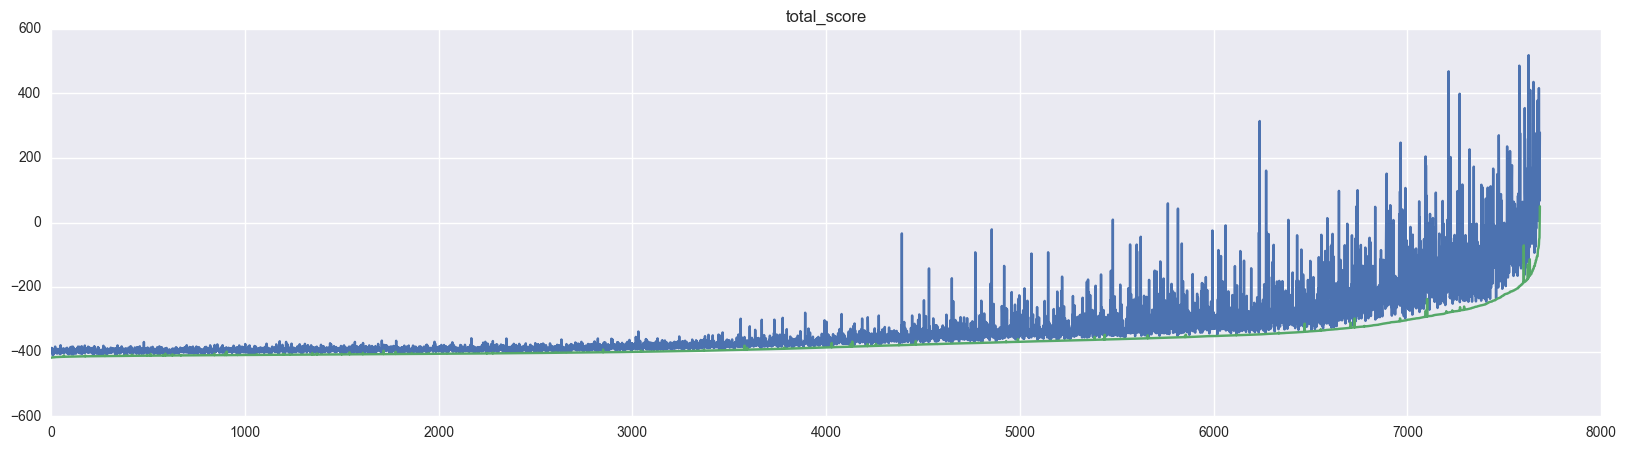

In [8]:

sc = [max(cc) for cc in sorted_vals_after_relax if len(cc)>1]
sc2 = [min(cc) for cc in sorted_vals_after_relax if len(cc)>1]
fig,ax = plt.subplots(figsize=(20, 5))
plt.plot(sc)
plt.plot(sc2)
plt.title(headers[term])

In [9]:
sorted_keys = sorted_keys[:500]
sorted_vals = sorted_vals[:500]
sorted_keys_after_relax = sorted_keys_after_relax[:500]
sorted_vals_after_relax = sorted_vals_after_relax[:500]

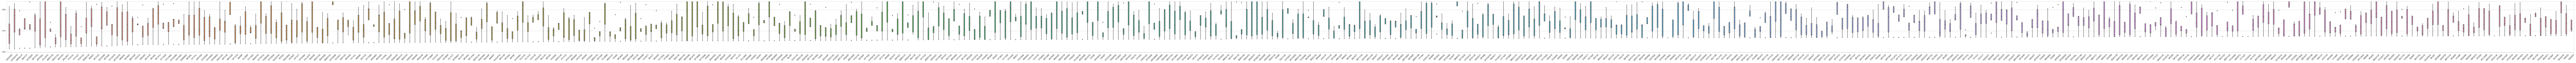

In [10]:
sns.set_style("whitegrid", {'grid.linestyle': '-'})
fig,ax = plt.subplots(figsize=(len(sorted_keys_after_relax) / 2.0, 5))
g =sns.boxplot(data=sorted_vals_after_relax, width=.18)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.xticks(plt.xticks()[0], sorted_keys_after_relax)
y_max = int(max(sorted_vals_after_relax[int(len(sorted_vals_after_relax)*0.9)]))
y_min = int(min(sorted_vals_after_relax[0]))
ax.set_ylim(y_min,y_max)
ax.set_yticks(np.arange(y_min-float(y_max-y_min)/10,y_max,float(y_max-y_min)/20), minor = False)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
#g.axes.set_title("talaris2014 centered terms after relaxation ("+ str(dat.shape[0]) + " runs)", fontsize=26) 

In [ ]:
# plot delta rank function to show the need for a relaxation step - if a lot of mutations change a lot in terms of rank - maybe we need a relax
# scatter with labels to show that relaxation does not change the relative "score" - mutation position in a sorted list
# if true this means that we can omit the relaxation step after backrub

In [ ]:
sorted_data_after_relax = sorted(zip(mut_scores.items(), mut_scores_after_relax.items()), key=lambda x: np.array(x[0][1]).mean())

In [ ]:
rank_before_relax = [sorted_keys.index(v[0][0]) for v in sorted_data_after_relax]
rank_after_relax = [sorted_keys_after_relax.index(v[1][0]) for v in sorted_data_after_relax]
delta_rank = [a - b for a,b in zip(rank_after_relax,rank_before_relax)]

In [ ]:
plt.plot(delta_rank)
print np.array(delta_rank).std()

In [ ]:
# the variance is too damn high!
# this is just more evidence which shows that the error in the lower energy structures 
# does not allow us to select few of the best mutants

In [ ]:
v1 = [min(v[0][1]) for v in sorted_data_after_relax]
v2 = [min(v[1][1]) for v in sorted_data_after_relax]
labels = [v[1][0] for v in sorted_data_after_relax]

In [ ]:
pl, ax = plt.subplots(figsize=(50, 50))
plt.scatter(v1,v2)
x_min = (min(v1) - sorted(v1)[-int(len(v1)*0.15)]) / 10.0  + min(v1)
x_max = sorted(v1)[-int(len(v1)*0.25)]
y_min = (min(v2) - sorted(v2)[-int(len(v2)*0.15)]) / 10.0  + min(v2)
y_max = sorted(v2)[-int(len(v2)*0.25)]


plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
for label, x, y in zip(labels, v1, v2):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-5, 5),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [ ]:
# plot mutants by the ligand energy

In [11]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/")
#f = open("xop_energies_after_relax.dat")
f = open("all_xop_energies.dat")
lines = f.readlines()
f.close()

xop_scores = {}
total_energy_cutoff = -400

for line in lines:
    l = line.split()
    
    mut_type = line.split()[0][:-5]
    if len(l) < 2: continue
    
    if xop_scores.has_key(mut_type):
        xop_scores[mut_type].append(float(l[1])) # append total score
    else:
        xop_scores.update({mut_type:[]})
        xop_scores[mut_type].append(float(l[1])) # append total score
        
        
for v in xop_scores.items():
    # intersect with total score
    if np.array(mut_scores_after_relax[v[0]]).min() > total_energy_cutoff:
        xop_scores.pop(v[0], None)

IOError: [Errno 2] No such file or directory: 'all_xop_energies.dat'

In [ ]:
sorted_keys, sorted_vals = zip(*sorted(xop_scores.items(), key=lambda x: min(x[1])))#np.array(x[1]).mean())) #
sorted_vals = list(sorted_vals)
for key,val in zip(sorted_keys, sorted_vals):
    if len(val) > 5:
        sorted_vals[sorted_vals.index(val)] = val[-5:]

    

In [ ]:
sorted_keys = sorted_keys[:100]
sorted_vals = sorted_vals[:100]

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': '-'})
fig,ax = plt.subplots(figsize=(len(sorted_keys) /4.0, 5))
g =sns.boxplot(data=sorted_vals, width=.5)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.xticks(plt.xticks()[0], sorted_keys)
y_min = int(1.4*min(sorted_vals[0]))


In [ ]:
sc = [min(cc) for cc in sorted_vals]
sc2 = [max(cc) for cc in sorted_vals]
plt.plot(sc)
#plt.plot(sc2)

In [ ]:
###### get WT on plots!!!!!!!!!!!!!!!!!!
# intersect several criteria (for example: xop energy and total energy)
# CHECK THE DISTANCE BETWEEN REACTING ATOMS!!!!
# select best mutants

In [ ]:
# limit the mutations basing on energy (total)
# generate triple resfiles

# several TS

In [77]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/backrub_output/")

In [78]:
# get WT energies total and only ligand
with open("wt_score.sc") as f:
    lines = f.readlines()
wt_tot = {}
for line in lines:
    l = line.split()
    wt_tot.update({l[0][:-14]:float(l[1])})
    
with open("a5R_wt_energies.dat") as f:
    lines = f.readlines()
wt_xop = {}
for line in lines:
    l = line.split()
    wt_xop.update({l[0][:-8]:float(l[1])+float(l[2])})
    
    
with open("a5S_wt_energies.dat") as f:
    lines = f.readlines()

for line in lines:
    l = line.split()
    if wt_xop.has_key(l[0][8:-5]):
        wt_xop[l[0][8:-5]].append(float(l[1])+float(l[2]))
    else:
        wt_xop.update({l[0][8:-5]:[float(l[1])+float(l[2])]})

sorted_wt_xop_keys, sorted_wt_xop_vals = zip(*sorted(wt_xop.items(), key=lambda x: x[1]))
sorted_wt_xop_vals = list(sorted_wt_xop_vals)

In [84]:
sorted_wt_xop_vals[16]

[6.044, 11.929, 17.372999999999998, 23.055999999999997, 29.102]

In [95]:
sorted_wt_xop_vals[16][-1]/len(sorted_wt_xop_vals[16])

5.8204

In [94]:
np.array([gv(sorted_wt_xop_vals[16],c[0]) for c in enumerate(sorted_wt_xop_vals[16])]).mean()

5.8204000000000002

In [106]:
# averaging the scores over repeats?
swxv = []
swxvR = []
swxvS = []
for a in sorted_wt_xop_vals:
    mean = a
    if type(a) == list:
        mean = a[-1]/len(a)
    swxv.append(mean)

for aa in zip(sorted_wt_xop_vals,sorted_wt_xop_keys):
    a = aa[0] # val
    b = aa[1] # key
    mean = a
    if type(a) == list:
        mean = a[-1]/len(a)
    if ("a5R" in b):
        swxvR.append(mean)
    if ("a5S" in b):
        swxvS.append(mean)   

In [97]:

f = open("all_score.dat")
lines = f.readlines()
f.close()
headers = []
mut_scores = {}
mut_scores_after_relax = {}
i=0

term = 0 # of the energy column
for line in lines:
    
    l = line.split()[1:-1]
    if len(l) < 1: continue
    # get column headers
    
    if l[0] == "total_score": 
        headers = l
        print "found headers, using term: " + headers[term]
        continue
        
   
    mut_type = line.split()[-1][2:-14]

    if len(mut_type) == 0:
    #    print "line is: " + line
        print "skipping empty mutation"
        continue
    if "relaxed" in mut_type: # that was an S type XOP
        continue
    if "_low_0001" in line: # store relaxed mutations separately
        if not mut_scores_after_relax.has_key(mut_type):
            mut_scores_after_relax.update({mut_type:[]})
        mut_scores_after_relax[mut_type] = [float(l[term])]
        continue    
            
    if not mut_scores.has_key(mut_type):
        mut_scores.update({mut_type:[]})
    mut_scores[mut_type].append(float(l[term])) 
    
sorted_keys, sorted_vals = zip(*sorted(mut_scores.items(), key=lambda x: min(x[1])))#np.array(x[1]).mean()))
sorted_keys_after_relax, sorted_vals_after_relax = zip(*sorted(mut_scores_after_relax.items(), key=lambda x: min(x[1])))#np.array(x[1]).mean())) #
sorted_vals = list(sorted_vals)
sorted_vals_after_relax = list(sorted_vals_after_relax)


found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
found headers, using term: total_score
skipping empty mutation
skipping empty mutation
skipping empty mutation
skipping empty mutation
skipping empty mutation
skipping empty mutation
skipping empty mutation
skipping empt

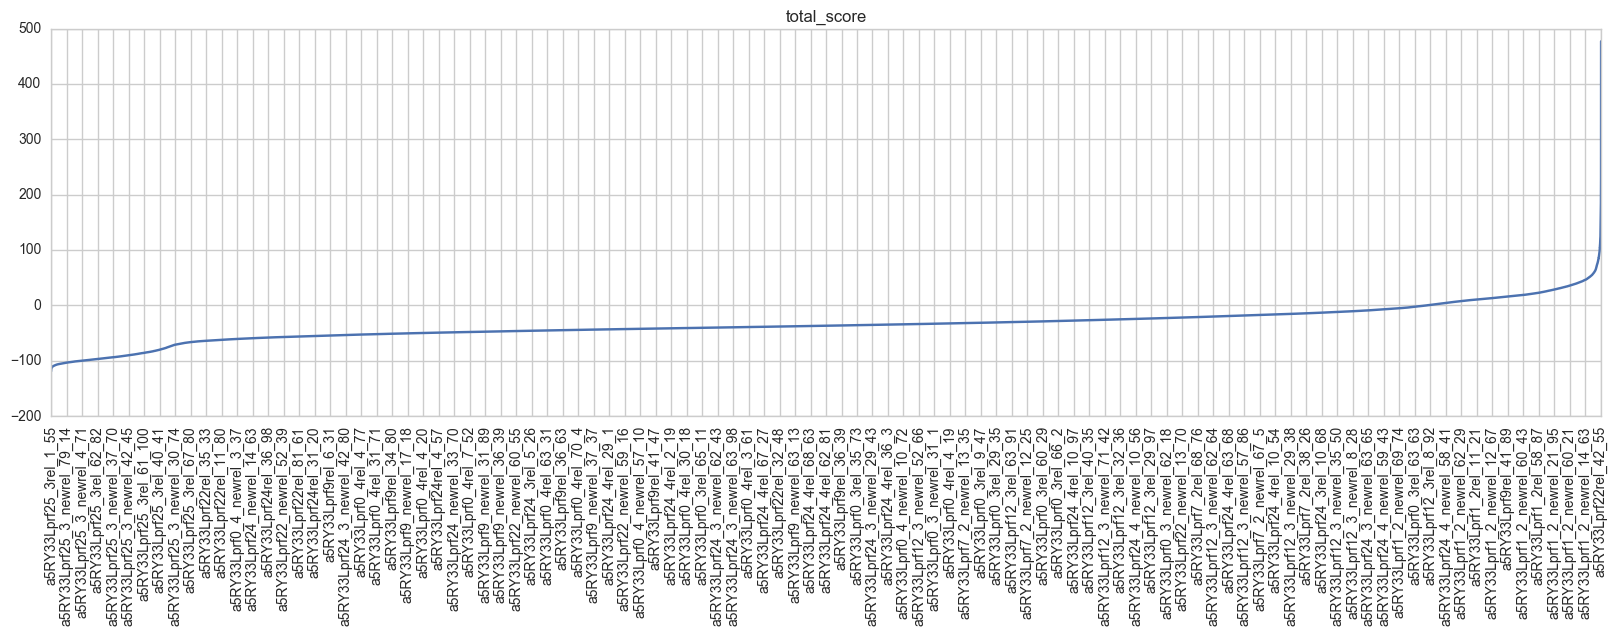

In [23]:
sc = [cc[0] for cc in sorted_vals_after_relax]
fig,ax = plt.subplots(figsize=(20, 5))
plt.xticks(range(0,len(sc),len(sc)/100), sorted_keys_after_relax[::len(sc)/100], rotation="vertical")
plt.plot(sc)
plt.title(headers[term])

In [98]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/backrub_output/")

f = open("all_248_xop_energies.dat")
lines = f.readlines()
f.close()

xop_scores = {}
total_energy_cutoff = 0

for line in lines:
    l = line.split()
    
    mut_type = line.split()[0][2:-19]
    
    if len(mut_type) == 0:
        print "skipping empty mutation"
        continue

    if "a5RY33Lprf" not in mut_type:
        continue
    if len(l) < 2: continue
    
    if xop_scores.has_key(mut_type):
        
        xop_scores[mut_type].append(float(l[1])+float(l[2])) 
    else:
        xop_scores.update({mut_type:[]})
        xop_scores[mut_type].append(float(l[1])+float(l[2])) 
        
        
for v in xop_scores.items():
    # intersect with total score
    if mut_scores_after_relax[v[0]][0] > total_energy_cutoff:
        xop_scores.pop(v[0], None)

In [99]:
sorted_keys, sorted_vals = zip(*sorted(xop_scores.items(), key=lambda x: x[1]))
sorted_vals = list(sorted_vals)

In [100]:
sns.set_style("white")

In [110]:
wt_xop_xsS

[219,
 2635,
 3139,
 5645,
 8667,
 12848,
 32165,
 42194,
 45745,
 52667,
 60245,
 59967,
 61664,
 64695,
 65498]

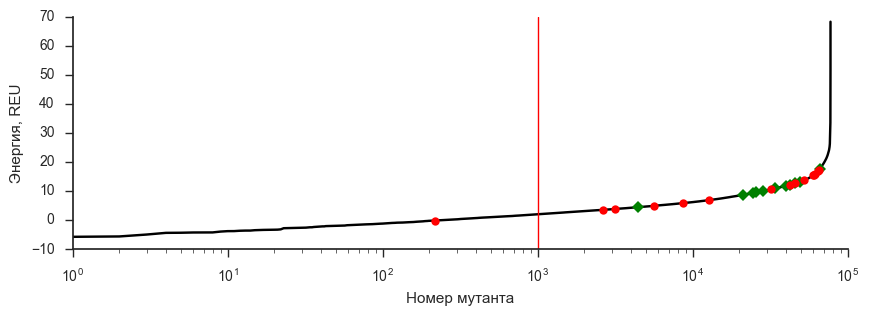

In [533]:
sc = sorted([cc[1][0] for cc in xop_scores.iteritems()])
wt_xop_xsR = []
wt_xop_xsS = []
for a in swxvR:
    s = min(sc, key=lambda x: abs(x - a))
    wt_xop_xsR.append(sc.index(s))
for a in swxvS:
    s = min(sc, key=lambda x: abs(x - a))
    wt_xop_xsS.append(sc.index(s)) 



fig,ax = plt.subplots(figsize=(10, 3))
plt.plot(sc,'k')#, marker="o", color=cl,markevery=wt_xop_xs)
i = 1

for label,x,y in zip(sorted_wt_xop_keys,wt_xop_xs, swxv):
    i *= -1
    rn = (1 + randint(10))/ 4.0
    if "a5S" in label:
        label = "Swt"
        cl = "red"     
    else:
        label = "Rwt"
        cl = "black"

plt.plot(sc, "_", marker="D",markersize=6,color="green",markevery=wt_xop_xsR)
plt.plot(sc, "_", marker="o",markersize=6,color="red",markevery=wt_xop_xsS)
    #plt.annotate(label,xy=(x, y), xytext=(10,30*i*rn), color = cl,textcoords='offset points', ha='left', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0.1'))
    
#plt.xticks(range(0,len(sc),len(sc)/100), sorted_keys[::len(sc)/100], rotation="vertical")
#plt.title(u"Распределение структур по энергии",fontweight="bold")
plt.ylabel(u"Энергия, REU")
plt.xlabel(u"Номер мутанта")
ax.set_xscale("log", nonposx='clip')
sns.despine()
plt.plot([1000,1000], [-10, 70], color='r', linestyle='-', linewidth=1)

In [15]:
from shutil import copyfile
#re.search("^.*rel","relaxed_rel.fdas")


for a in sorted_keys[:1000]:
    dr = re.findall("^.*rel",a)[0][:-3]
    f = "relaxed" + re.findall("rel.*",a)[0][3:] + "_0001_low_0001.pdb"
    copyfile(dr + "/" + f, "for_stability_check/" + a + ".pdb")


IndexError: list index out of range

Iteration 1. Expected coverage 20.0%.
Iteration 2. Expected coverage 36.0%.
Iteration 3. Expected coverage 48.8%.
Iteration 4. Expected coverage 59.04%.
Iteration 5. Expected coverage 67.232%.
Iteration 6. Expected coverage 73.7856%.
Iteration 7. Expected coverage 79.02848%.
Iteration 8. Expected coverage 83.222784%.
Iteration 9. Expected coverage 86.5782272%.
Iteration 10. Expected coverage 89.26258176%.
Iteration 11. Expected coverage 91.410065408%.
Iteration 12. Expected coverage 93.1280523264%.
Iteration 13. Expected coverage 94.5024418611%.
Iteration 14. Expected coverage 95.6019534889%.
Iteration 15. Expected coverage 96.4815627911%.
Iteration 16. Expected coverage 97.1852502329%.
Iteration 17. Expected coverage 97.7482001863%.
Iteration 18. Expected coverage 98.1985601491%.
Iteration 19. Expected coverage 98.5588481192%.
Iteration 20. Expected coverage 98.8470784954%.
Iteration 21. Expected coverage 99.0776627963%.
Iteration 22. Expected coverage 99.2621302371%.
Iteration 23. Ex

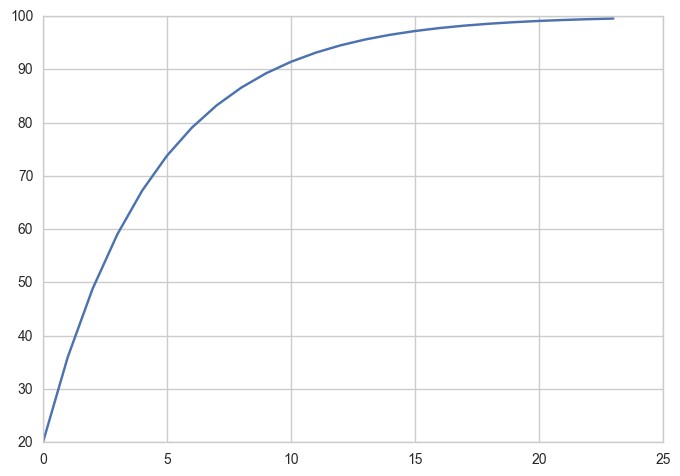

In [16]:
# coverage of uniform sampling 

H = 500.0
h = 100.0

p = [1]
covs = []
for a in range(1,25):
    #print p
    cov = 100*h/H * sum(p)
    covs.append(cov)
    print "Iteration " + str(a) + ". Expected coverage " + str(cov) + "%."
    p.append(1 - h / H * (sum(p)))
plt.plot(range(len(covs)),covs)
    

In [17]:
os.chdir("/home/domain/data/kirill/AB/XOP/qmmm/")
with open("mins") as mins:
    lines = mins.readlines()
    
mins = {}
for l in lines:
    mins.update({l.split()[0]:float(l.split()[1])})

IOError: [Errno 2] No such file or directory: 'mins'

In [ ]:
len(mins)

In [ ]:
plt.hist(sorted(mins.values()))

# STABILITY ASSERTION

In [555]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    angle = np.arccos(np.dot(v1_u, v2_u))
    if np.isnan(angle):
        if (v1_u == v2_u).all():
            return 0.0
        else:
            return np.pi
    return angle
def xyzs_to_ang(x0,x1,x2,y0,y1,y2,z0,z1,z2):
    return 57.3*angle((x1-x0,y1-y0,z1-z0),(x1-x2,y1-y2,z1-z2))

In [564]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/stability_check_out")


with open("oh-dists") as f:
    lines = f.readlines()

recs = {}
dists = []
angs = []
for l in lines:
    line = l.split()
    mutant = re.search("(a5.*)-em/",line[0]).group(1)
    if mutant not in recs and len(line) > 10:
        recs.update({mutant:[float(line[1])]})
        
    elif len(line) > 10:
        recs[mutant].append(float(line[1]))
    if len(line) > 10:
        if float(line[1]) > 20: continue
        dists.append(float(line[1])*10)
        angs.append(xyzs_to_ang(*[float(zxc) for zxc in line[2:]]))
        
shortEntries = []
for l in recs.iteritems():
    if len(l[1]) < 35:
        shortEntries.append(l[0])
for e in shortEntries:
    recs.pop(e)
    
with open("median_dist", "w") as f:
    for key,val in sorted([(k[0],sorted(k[1])[19]) for k in recs.items() if len(k[1]) >= 40], key=lambda x: x[1]):
        f.write(key+"\t"+str(val)+"\n")


In [565]:
zip(*recs.items()[:4])[0]

('a5RY33Lprf0_3rel_13_63',
 'a5RY33Lprf0_3rel_13_61',
 'a5RY33Lprf9rel_39_58',
 'a5RY33Lprf7_2_newrel_7_46')

In [566]:
sorted_muts, sorted_dist = zip(*recs.items())
meds = [np.median(a) for a in sorted_dist]

In [567]:
sorted_muts = [m[1] for m in sorted(zip(meds,sorted_muts))]
medians = sorted(meds)

In [568]:
import scipy

xmin = 5
xmax = 12
ymin = 0
ymax = 180

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([dists, angs])
kernel = scipy.stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


In [569]:
low_values_indices = f < 1e-3  # Where values are low
#f[low_values_indices] = -0.0001  # All low values set to 0

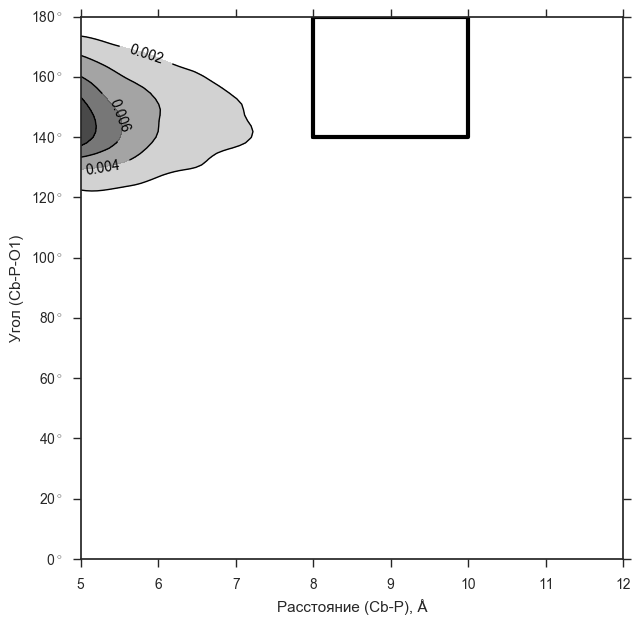

In [570]:
sns.set_style("ticks")

fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
#plt.scatter(dists, angs, alpha=0.15,s=2)
cfset = ax.contourf(xx, yy, f,5, cmap='gray_r', alpha=0.8,vmin=0.001, vmax=0.01)
cset = ax.contour(xx, yy, f,5, colors='k',linewidths=1)

# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel(u'Расстояние, \u0123')
ax.set_yticklabels([str(a)+u"$^\circ$" for a in range(ymin,ymax+1,20)])
#cfset.cmap.set_under('w')
#cfset.set_clim(0, 0.01)

#cb = plt.colorbar(cfset)
#cb.set_clim(0,0.1)
#plt.title(ur"Оценка плотности комплексов после МД",fontweight="bold")
plt.xlabel(ur"Расстояние (Cb-P), \u00c5")
plt.ylabel(u"Угол (Cb-P-O1)")
plt.plot([8,8,8,10,10,10,10,8],[140,180,180,180,180,140,140,140], color="black", linewidth=3)

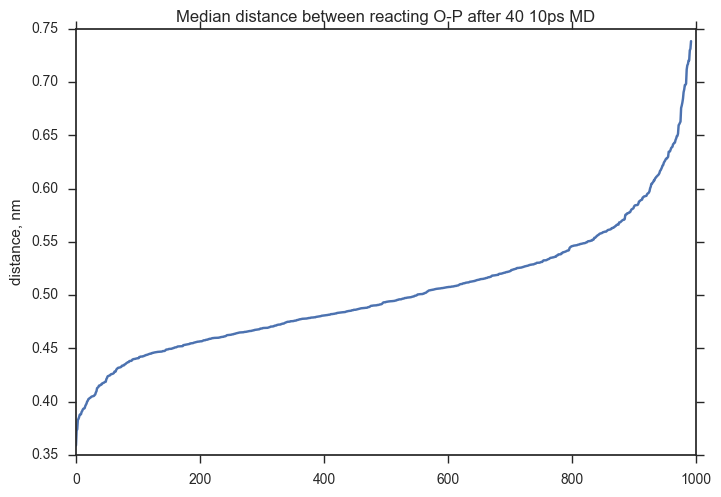

In [571]:
plt.plot(sorted(medians))
plt.title("Median distance between reacting O-P after 40 10ps MD")
plt.ylabel("distance, nm")

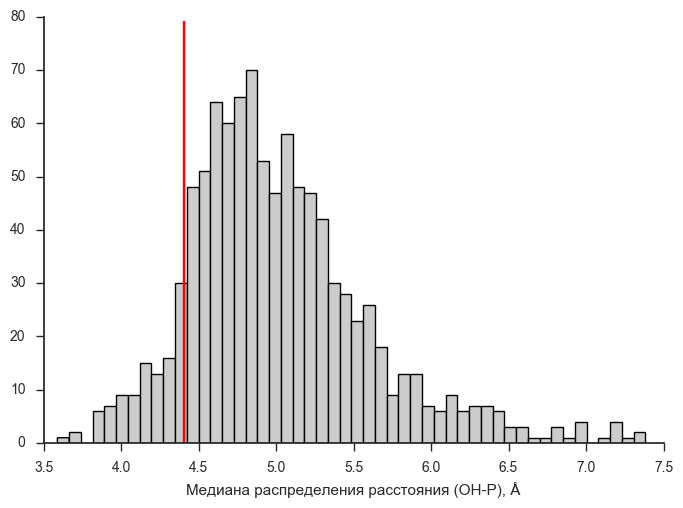

In [572]:
sns.set_style("ticks")

plt.hist([10*m for m in medians], bins = 50,fc=(0.8, 0.8, 0.8, 1), lw=1)
sns.despine()
#plt.xticks(np.arange(5,10,0.5))
#plt.title(u"Гистрограмма мединаны распределения расстояния после МД", fontweight='bold')
plt.xlabel(u"Медиана распределения расстояния (OH-P), \u00c5")
plt.plot([10*sorted(medians)[100]]*80,range(80),color="r")

In [347]:
sorted_muts = sorted_muts[0:100]
sorted_dist = sorted_dist[0:100]

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': '-'})
fig,ax = plt.subplots(figsize=(len(sorted_muts) / 2.0, 5))
g = sns.boxplot(data=sorted_dist, width=.18)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.xticks(plt.xticks()[0], sorted_muts)
y_max = max(sorted_dist[int(len(sorted_dist)*0.9)])
y_min = min(sorted_dist[0])
ax.set_ylim(y_min,y_max)
ax.set_yticks(np.arange(0.3,0.75,0.05))
#ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
plt.title("Distance between reacting O-P after 40 10ps MD, sorted by median")
#g.axes.set_title("talaris2014 centered terms after relaxation ("+ str(dat.shape[0]) + " runs)", fontsize=26) 

In [ ]:
# for the final analysis
for a in sorted_muts[:10]:
    print a

In [ ]:
# get the best gros

with open("dist") as f:
    lines = f.readlines()

recs = {}

for l in lines:
    line = l.split()
    mutant = re.search("(a5.*)-em/",line[0]).group(1)
    if mutant not in recs and len(line) > 1:
        recs.update({mutant:[(line[0],float(line[1]))]})
    elif len(line) > 1:
        recs[mutant].append((line[0],float(line[1])))
        
shortEntries = []
for l in recs.iteritems():
    if len(l[1]) < 38:
        shortEntries.append(l[0])
for e in shortEntries:
    recs.pop(e)
    
gogo = []
for sm in sorted_muts[50:100]:
    l = recs[sm]
    gogo.append([a[0] for a in sorted(l, key=lambda x: x[1])[:3]])
    
with open("best_gros2", "w") as f:
    f.writelines([g+"\n" for go in gogo for g in go])
    

In [ ]:
"""
for a in `cat ../stability_check_out/best_gros2`; 
do 
    cp ../stability_check_out/$a .; 
done

for a in `cat ../stability_check_out/best_gros2`; 
do 
    k=${a%%-*}"-em"; 
    f=${a##*/}; 
    cp ../for_stability_check/after_em/${k:2}".top" ${f%.*}".top"; 
    cp ../for_stability_check/after_em/${k:2}".itp" ${f%.*}".itp"; 
done

cp -r ../for_stability_check/after_em/xopR.itp ../for_stability_check/after_em/posre* .
for a in *; do sed -i 's/XOP/XQM/g' $a; done
cp -r ../for_stability_check/transition/amber99sb-ildnp.ff .
for a in *; do sed -i 's/ildn/ildnp/g' $a; done

parallel "bash ../../../md-qmmm-transition/scripts/merge_tops_after_rosetta.bash {}" ::: `find . -name "*nvt*gro" ! -name "*qm*"`
parallel "python ../../../md-qmmm-transition/scripts/make_qm_system_mutants.py {}" ::: `find . -name "*nvt*-qm*gro"`
bash last.bash
 
 
for a in `find -name "COLVAR"`; 
do  
    k=`awk '{if ($3 < 0.17){print FILENAME; exit;}}' $a`; 
    echo $k | grep -o prf.*-em; 
done > reacted

sort reacted | uniq -c
 
"""

# aggregate qmmm energy minima

In [ ]:
# BASH HELP
# get success_rate.bash should handle everything

# rdf plotting

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/stability_check_out/")

In [ ]:
for a in os.walk("."):
    dirs = a[1]
    break

In [ ]:
rdf = []
for d in dirs:
    try:
        with open(d + "/rdf_cn.xvg") as f:
            lines = f.readlines()
        x = [float(l.split()[0]) for l in lines]
        y = [float(l.split()[1])  for l in lines]
        z = [k[1] for k in zip(y,x) if k[0] >= 50] # if more than 50 waters

        rdf.append((z[0],d))
        plt.plot(x, y, linewidth=0.2)
    except IOError:
        pass


In [ ]:
# RDF distribution
plt.hist(sorted([dd[0] for dd in rdf]), bins = 25)

In [ ]:
# stable vs rdf
# probability to get top rdf hits with increasing sample size of mutnants, ranked by stability
mutants = [dd[1][:-3] for dd in sorted(rdf)]

for a in [50]:
    ranks = []
    for i in range(len(sorted_muts)):
        muts = sorted_muts[:i+1]
        ranks.append(np.percentile([mutants.index(m)/float(len(mutants)) for m in muts if m in mutants],a))
    plt.plot(ranks)
plt.show()

# correlations of stability - success-rate - energy  

In [482]:
os.chdir("/home/domain/data/kirill/AB/XOP/qmmm/mutants/stable/a5R_mutants_stable_out/")
with open("qmmm_results.dat") as f:
    lines = f.readlines()

In [483]:
qmmm = []
qm_rank_dat = []
mean_ens = []
min_ens = []
suc_rts = []
qm_dat = []


###
### make sure sorted_dist and sorted_muts are correctly calculated above
###
stable_dic = {}
medians = [np.median(i) for i in sorted_dist]
for c in range(len(medians)):
    stable_dic.update({sorted_muts[c] : sorted(medians).index(medians[c])})


# read data
for line in lines:
    l = line.split(",")
    mean_ens.append(int(l[1]))
    min_ens.append(int(l[3]))
    suc_rts.append(float(l[4]))
    qmmm.append(l[0]) 
    
    
# append ranks
for i in range(len(qmmm)):
    mutant = qmmm[i]
    
    qm_rank_dat.append([])
    
    qm_rank_dat[i].append(sorted(mean_ens).index(mean_ens[i]))
    qm_rank_dat[i].append(sorted(min_ens).index(min_ens[i]))
    qm_rank_dat[i].append(sorted(suc_rts, reverse = True).index(suc_rts[i]))
    qm_rank_dat[i].append(stable_dic["a5RY33L" + mutant[:-3]])
    
    qm_dat.append([])
    qm_dat[i].append(mean_ens[i])
    qm_dat[i].append(min_ens[i])
    qm_dat[i].append(suc_rts[i])
    qm_dat[i].append(med_dist_dic["a5RY33L" + mutant[:-3]])

In [481]:
kkk = data.sort(columns="Min reacted energy",ascending = False).reset_index(drop=True)
kkk[kkk["Median distance"] == np.median(sorted_dist[sorted_muts.index("a5RY33Lprf12_3_newrel_8_34")])]

NameError: name 'data' is not defined

                                   Средняя энергия депротонирования  \
Средняя энергия депротонирования                           1.000000   
Min reacted energy                                         0.757532   
Доля успешных реакций                                     -0.053606   
Мединана распределения расстояния                         -0.190762   

                                   Min reacted energy  Доля успешных реакций  \
Средняя энергия депротонирования             0.757532              -0.053606   
Min reacted energy                           1.000000              -0.364041   
Доля успешных реакций                       -0.364041               1.000000   
Мединана распределения расстояния            0.021034              -0.326493   

                                   Мединана распределения расстояния  
Средняя энергия депротонирования                           -0.190762  
Min reacted energy                                          0.021034  
Доля успешных реакций         

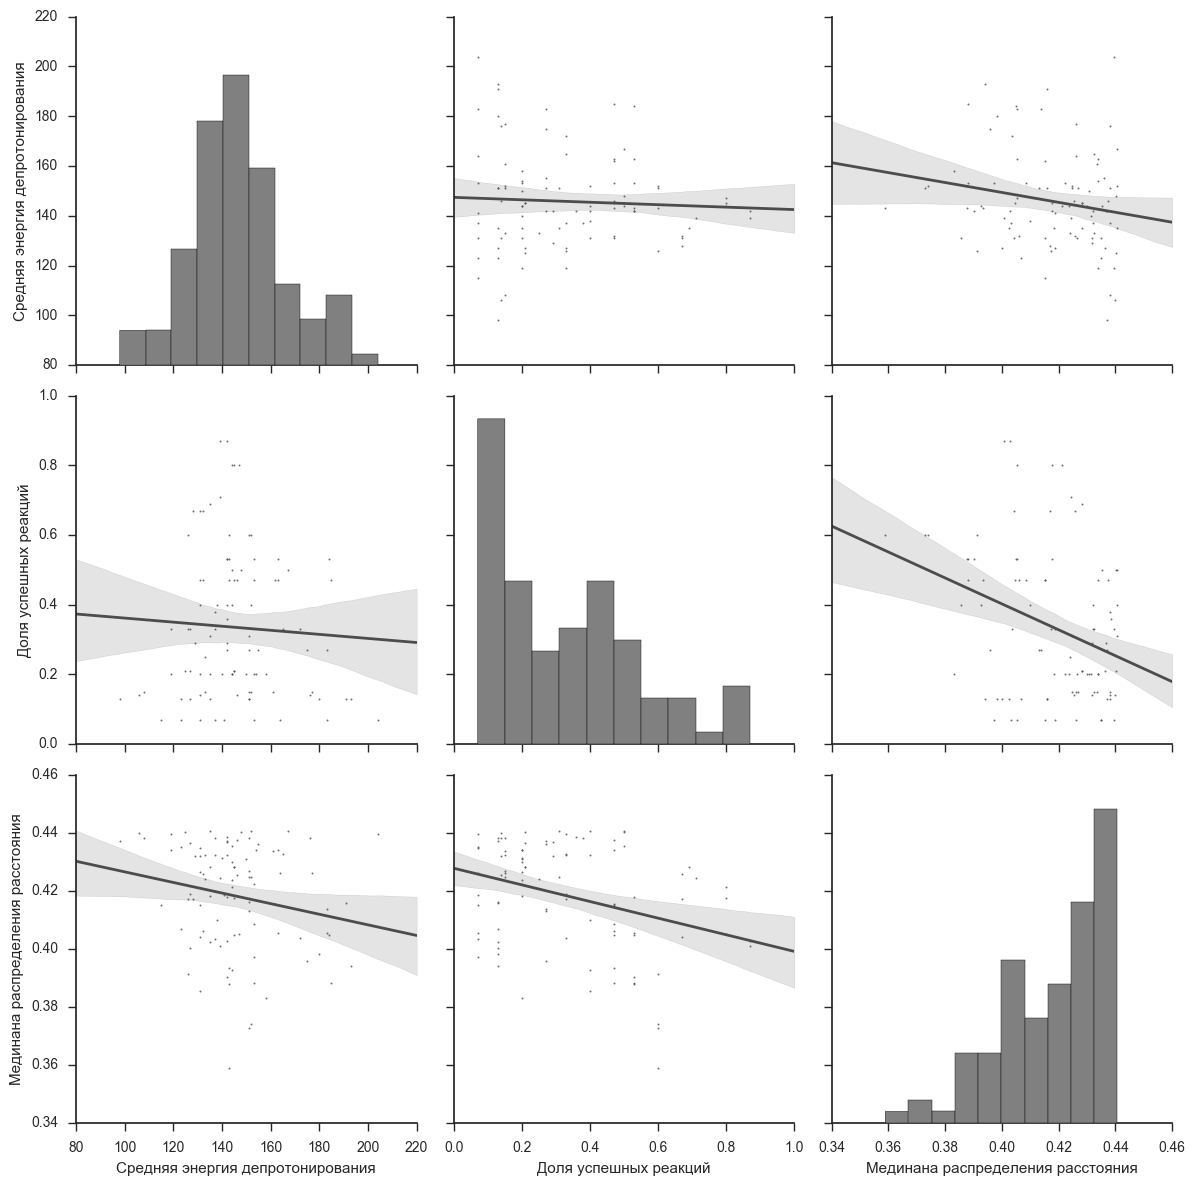

In [530]:
import pandas
data = pandas.DataFrame(qm_dat, columns=[u"Средняя энергия депротонирования", u"Min reacted energy", u"Доля успешных реакций", u"Мединана распределения расстояния"])
print data.corr()
sns.set_style("ticks",{"color":"k"})
g = sns.PairGrid(data.drop("Min reacted energy",1),size=4)
g = g.map_diag(plt.hist,facecolor="grey")

#g = g.map_offdiag(plt.scatter, s=2, color= "black")
g = g.map_offdiag(sns.regplot, color = "0.3", scatter_kws={"s":2}, line_kws={"lw":2})

# Mutant structure analysis

In [20]:
from xmlrpclib import ServerProxy
from IPython.display import Image

In [21]:
# pymol launching
import sys
sys.path.append('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages')

import __main__
__main__.pymol_argv = ['pymol', '-cp']

import pymol
pymol.finish_launching()

 
from pymol import cmd

In [22]:
def subs(res):
    """
    accepts a residue number from fv renumbered from 1
    returns original numbering
    """
    if res <= 117:
        return "H" + str(res+1)
    if res > 117:
        return "L" + str(res-115)

In [23]:
substitution = {33: 'H34',
                34: 'H35',
                35: 'H36',
                36: 'H37',
                37: 'H38',
                38: 'H39', 
                48: 'H49',
                50: 'H51',
                51: 'H52',
                52: 'H53',
                53: 'H54',
                59: 'H60', 
                97: 'H98',
                98: 'H99', 
                99: 'H100', 
                100: 'H101', 
                101: 'H102', 
                102: 'H103', 
                103: 'H104',  
                104: 'H105',
                105: 'H106', 
                107: 'H108', 
                142: 'L27', 
                146: 'L31', 
                147: 'L32', 
                149: 'L34', 
                150: 'L35', 
                152: 'L37', 
                162: 'L47', 
                165: 'L50', 
                166: 'L51',
                167: 'L52',
                205: 'L90', 
                206: 'L91', 
                207: 'L92', 
                208: 'L93', 
                209: 'L94',
                210: 'L95',
                211: 'L96',
                212: 'L97', 
                213: 'L98', 
                214: 'L99', 
                215: 'L100'}


# returns 
substitution_back = {'H34':33,
                     'H35':34,
                     "H36":35,
                     'H37':36,
                     'H38':37,
                     'H39':38,
                     'H49':48, 
                     'H51':50,
                     'H52':51,                    
                     'H53':52,
                     'H54':53,
                     'H60':59,
                     'H98':97,
                     'H99':98,
                     'H100':99,
                     'H101':100,    
                     'H102':101,
                     'H103':102,
                     'H104':103,
                     'H105':104,
                     'H106':105,
                     'H108':107,            
                     'L96':211,
                     'L98':213,
                     'L99':214,
                     'L27':142,
                     'L31':146,
                     'L32':147,
                     'L34':149,
                     'L35':150,
                     'L37':152,
                     'L47':162,
                     'L50':165,
                     'L51':166,
                     'L52':167,
                     'L90':205,
                     'L91':206,
                     'L92':207,
                     'L93':208,
                     'L94':209, 
                     'L95':210,
                     'L97':212,
                     'L100':215
                    }

def get_substitution(s1, s2, x):
    """
    s1 - WT sequence
    s2 - Mutant sequence
    x - position in sequence as indexed by Python
    """

    if s1[x] == s2[x]:
        return substitution[x+1] + ": " + s1[x] 
    return substitution[x+1] + ": " + s1[x] + " => " + s2[x]


def get_ligand(val):
    """
    a function returning substituent of the ligand, given the ligand heavy atom name
    """
    ligand = {
    "Phen":["C8","C9","C10","C12","C13","C14"],
    "Trop":["O","C","C1","C2","C3","C4","C5","C6","C7","N"],
    "O-P":["O2"],
    "P":["P"],
    "pNPh" : ["O3","O4","N1","C15","C16","C17","C18","C19","C11","O1"]    
    }
    for key, vals in ligand.items():
        if val in vals:
            return key
    return "ERROR !!! "

def get_ligand_substituents_contacts(dc):
    """
    function take a residue contacts dic
    {"CG":["C14","C12], "CB":["C14","C11"]}
    and returns a string summary of contacts by ligand substituents
    """
    contacts_subs = [get_ligand(vv) for v in dc.values() for vv in v]
    return ", ".join([" - ".join([str(zz) for zz in k]) for k in Counter(contacts_subs).iteritems()])



# fix pdb names to XRD

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/logo_generation/")
with open("sequences_for_qm_stable") as f:
    lines = f.readlines()

sex = {}
for l in lines:
    l = l.split()
    sex.update({l[0]:l[1]})
    
    
with open("wild_type") as f:
    wt_sex = f.readlines()[0].strip()

CUTOFF_CAR = str(4.2)
CUTOFF_HET = str(3.5)

# get wild type contacts

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/backrub_input_structures/")

wt = {}

for pdb in [pp for pp in os.listdir(".")  
    if "relaxed.pdb" in pp]:

    output = []
    cmd.reinitialize()
    protein = pdb[:-4]
    print protein
    cmd.load(pdb)

    conts_dists = []
#     for contact in contacts:
#         conts_dists.append([cmd.distance("wtf",*["index " + str(c[1]) for c in contact]),contact])
#     print cmd.get_atom_coords("index " + str(contacts[0][0][1]))


    myspace = {'protein': [],
               'ligand': [],
               'resi': [],
               'atoms': [],
               'resn': []}
    cmd.select("ligand","resn xop and not symbol H")
    cmd.select("protein", "not (resi 148 or ligand) and symbol C within "+
               CUTOFF_CAR+" of (ligand and symbol C)") # create a c-c neighbours selection
    cmd.select("protein", "protein or (not (resi 148 or resn xop) and (symbol N or symbol O) within "+
               CUTOFF_HET+" of (ligand and (symbol O or symbol N)))") # add het to selection
    cmd.iterate('protein','protein.append((resn, resi, name, elem))', space = myspace) ###
    cmd.iterate('ligand','ligand.append((resn, resi, name, elem))', space = myspace) ###
    
    contacts = dict()
    lig_contacting = []
    last = 0
    for resn1,resi1, name1, elem1 in myspace['protein']:  
        if elem1 in "C":
            el2 = "C"
            CUTOFF = CUTOFF_CAR
        if elem1 in "ON":
            el2 = "ON"
            CUTOFF = CUTOFF_HET
        key = substitution[int(resi1)]
        if not key in contacts:
            contacts.update({key:{}})

        for resn2,resi2, name2, elem2 in myspace['ligand']: # get all ligand atoms contacting name1 of resi1
            if elem2 in el2:
                if cmd.get_distance('%s/%s'%(resi1, name1), '%s/%s'%(resi2, name2)) < float(CUTOFF):
                    if not name1 in contacts[key]:
                        contacts[key].update({name1:[]})
                    contacts[key][name1].append(name2)
                    #str(round(cmd.distance('%s/%s'%(resi1, name1), '%s/%s'%(resi2, name2)),2)))
            
    wt.update({protein:contacts})

# get for qm mutant contacts

In [ ]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/for_qm_stable_all_pdb/best_min_energy")

mutants = {}

for pdb in [pp for pp in os.listdir(".") if "a5RY33Lprf" in pp and "fix" not in pp]:
    
    """
    load wt contacts
    load mutant
    compare sequences
    get contacts in mutation positions
    compare with wt
    print
    """
    output = []
    cmd.reinitialize()
    protein = pdb[:-4]
    print protein
    cmd.load(pdb)

    conts_dists = []
#     for contact in contacts:
#         conts_dists.append([cmd.distance("wtf",*["index " + str(c[1]) for c in contact]),contact])
#     print cmd.get_atom_coords("index " + str(contacts[0][0][1]))


    myspace = {'protein': [],
               'ligand': [],
               'resi': [],
               'atoms': [],
               'resn': []}
    
    cmd.select("ligand","resn xqm and not symbol H")
    cmd.select("protein", "not (resi 148 or ligand or resn HOH) and symbol C within "+
               CUTOFF_CAR+" of (ligand and symbol C)") # create a c-c neighbours selection
    cmd.select("protein", "protein or (not (resi 148 or ligand or resn HOH) and (symbol N or symbol O) within "+
               CUTOFF_HET+" of (ligand and (symbol O or symbol N)))") # add het to selection
    cmd.iterate('protein','protein.append((resn, resi, name, elem))', space = myspace) ###
    cmd.iterate('ligand','ligand.append((resn, resi, name, elem))', space = myspace) ###
    
    
    contacts = dict()
    lig_contacting = []
    last = 0

    for resn1,resi1, name1, elem1 in myspace['protein']:  
        if elem1 == "C":
            el2 = "C"
            CUTOFF = CUTOFF_CAR
        if elem1 in "ON":
            el2 = "ON"
            CUTOFF = CUTOFF_HET
        key = substitution[int(resi1)]
        if not key in contacts:
            contacts.update({key:{}})

        for resn2,resi2, name2, elem2 in myspace['ligand']: # get all ligand atoms contacting name1 of resi1
            if elem2 in el2:
                if cmd.get_distance('%s/%s'%(resi1, name1), '%s/%s'%(resi2, name2)) < float(CUTOFF):
                    if not name1 in  contacts[key]:
                        contacts[key].update({name1:[]})
                    contacts[key][name1].append(name2)
                    #str(round(cmd.distance('%s/%s'%(resi1, name1), '%s/%s'%(resi2, name2)),2)))
    

            
    mutants.update({protein:contacts})
  



In [ ]:
sorted(mutants.keys())

In [ ]:
m

# compare contacts

In [ ]:
def get_substitution(s1, s2, x):
    """
    s1 - WT sequence
    s2 - Mutant sequence
    x - position in sequence as indexed by Python
    """

    if s1[x] == s2[x]:
        return substitution[x+1] + ": " + s1[x] 
    return substitution[x+1] + ": " + s1[x] + " => " + s2[x]

In [ ]:
###
### this cell deals with aggregation of the output contacts
###

for m in mutants.keys():
    
    if len(re.findall("a5RY33Lprf12_3rel_61_55-em",m)) == 0:
        continue
    out = {}
    print m

    w = [w for w in wt.keys() if w[:-8] in m][0] # get the corresponding mutant name
    
    wt_contacts = wt[w].keys() # and its contacts intersected with mutation positions
    mut_contacts = mutants[m].keys()
    for contact in sorted(list(set(wt_contacts + mut_contacts))): # iterate over all possible contact positions: wild type and mutant
        out.update({contact:[]})
        sub = get_substitution(wt_sex, sex[re.search(".*_[0-9]+",m).group(0)], substitution_back[contact]-1)
        if not contact in wt_contacts: # get all new contact positions
            out[contact].append(" " + sub + " new: " + get_ligand_substituents_contacts(mutants[m][contact])+ " | " +
                                "; ".join([kk + ":\t"  +",".join(mutants[m][contact][kk]) # join all ligand atoms
                                            for kk in mutants[m][contact].keys()]))  # with a single protein atom in the contact
            
        elif contact in wt_contacts and contact in mut_contacts: # get positions which were already contacting
            out[contact].append(" "+ sub + " old: "+ get_ligand_substituents_contacts(wt[w][contact]) + " | " +
                                " ".join([kk + ":\t"  +",".join(wt[w][contact][kk])
                                           for kk in wt[w][contact].keys()]))  
            out[contact].append(" " +  " new: "+ get_ligand_substituents_contacts(mutants[m][contact]) + " | " +
                                "; ".join([kk + ":\t"  +",".join(mutants[m][contact][kk])
                                           for kk in mutants[m][contact].keys()]))        
            wt_contacts.remove(contact)

    for contact_left in sorted(wt_contacts): # get the lost contacts
        sub = get_substitution(wt_sex, sex[re.search(".*_[0-9]+",m).group(0)], substitution_back[contact_left]-1)
        sub += "; old contacts: " + get_ligand_substituents_contacts(wt[w][contact_left]) + " | "
        out[contact_left].append(" " +  sub + " lost "+
                                 "; ".join([kk + ":\t"  +",".join(wt[w][contact_left][kk])
                                          for kk in wt[w][contact_left].keys()]))
    for o in sorted(out.items(), key = lambda x:x[0]):
        print " ".join(o[1])


In [ ]:
m

In [ ]:
m

##### cmd.("net_charge = 0")
cmd.iterate("all", "net_charge + partial_charge")
print('Net charge: ' + str(net_charge))

In [ ]:
# copy best mutants in each category to a separate dir

In [8]:
best_min_energy = [
    'a5RY33Lprf0_3rel_59_92', 
    'a5RY33Lprf9_newrel_60_11', 
    'a5RY33Lprf0_3_newrel_10_99', 
    'a5RY33Lprf12_3_newrel_39_39', 
    'a5RY33Lprf12_3_newrel_35_55', 
    'a5RY33Lprf0_3rel_8_22', 
    'a5RY33Lprf12_3rel_61_55', 
    'a5RY33Lprf9rel_34_52', 
    'a5RY33Lprf1_2rel_42_97', 
    'a5RY33Lprf0_3rel_32_82']


best_stable = [
    "a5RY33Lprf12_3_newrel_35_55",
               "a5RY33Lprf12_3_newrel_8_34",
                "a5RY33Lprf12_3rel_57_60",
                "a5RY33Lprf12_3rel_41_13",
                "a5RY33Lprf12_3rel_68_41",
                "a5RY33Lprf12_3_newrel_35_78",
                "a5RY33Lprf9rel_17_86",
                "a5RY33Lprf9rel_40_10",
                "a5RY33Lprf9rel_7_30",
                "a5RY33Lprf12_3_newrel_39_39"]

best_success_rate = ['a5RY33Lprf9_newrel_4_33', 
                     'a5RY33Lprf9rel_39_55', 
                     'a5RY33Lprf9rel_9_17', 
                     'a5RY33Lprf9rel_2_73', 
                     'a5RY33Lprf9rel_1_12', 
                     'a5RY33Lprf9rel_31_25', 
                     'a5RY33Lprf9_newrel_10_10', 
                     'a5RY33Lprf9rel_33_5', 
                     'a5RY33Lprf9rel_34_41', 
                     'a5RY33Lprf9_newrel_60_11']


In [185]:
print recs["a5RY33Lprf9_newrel_4_33"]

In [189]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/for_qm_stable_all_pdb/")
for a in best_min_energy:
    !cp {a}*fixed.pdb /home/domain/data/kirill/AB/XOP/rosetta/several_ts/best30/

# color mutants

In [33]:
os.chdir("/home/domain/data/kirill/AB/XOP/rosetta/several_ts/best_before_md/")


In [ ]:
# fill this out by yourself
mutant = "a5RY33Lprf9_newrel_4_33-fixed"
wt = "a5RY33Lprf9-fixed"
trop = ["D-L35T","R-L51Q"]
phen = ["T-L98V","A-L91G","V-L99T"]
pnph = ["S-H37Y", "F-H100A", "Y-H52A","T-H106S"]
rest = ["Y-H35T", "Y-L50A","V-L99T"]
atta = ["N-L32G", "W-L92S"]

In [64]:
# fill this out by yourself
mutant = "a5RY33Lprf9rel_9_17-fixed"
wt = "a5RY33Lprf9-fixed"
trop = ["D-L35A", "R-L51G"]
phen = ["T-L98V", "A-L91G", "W-L92A", "V-L99I"]
pnph = ["S-H37F", "Y-H52S", "F-H100G", "T-H106A"]
rest = ["Y-H35R", "Y-L50G"]

In [58]:
# fill this out by yourself
mutant = "a5RY33Lprf9rel_39_55-fixed"
wt = "a5RY33Lprf9-fixed"
trop = ["R-L51F", "D-L35A"]
phen = ["T-L98V", "W-L92S", "A-L91S"]
pnph = ["S-H37Y", "Y-H52A", "F-H100A"]
rest = ["Y-H35V","N-L32G","V-L34T","Y-L50A","V-L99A"]

In [68]:

mutant = "a5RY33Lprf0_3rel_59_92-fixed"
wt = "a5RY33Lprf0_3-fixed"
trop = ["Y-L50G"]
phen = ["D-L35A", "W-L92G"]
pnph = ["Y-H35F","Y-H52S", "F-H100G", "T-L98A"]
rest = ["T-H102D","N-L32G"]
atta = ["N-L32G", "W-L92S"]

In [75]:

mutant = "a5RY33Lprf9_newrel_60_11-fixed"
wt = "a5RY33Lprf9-fixed"
trop = ["D-L35T","R-L51Q","Y-L50G","T-H106V"]
phen = ["W-L92A","T-L98V"]
pnph = ["S-H37Y","Y-H52A","F-H100G"]
rest = ["Y-H35T","G-H101A","A-L91G","V-L99T"]
atta = ["N-L32S","V-L34T"]

In [90]:
mutant = "a5RY33Lprf0_3_newrel_10_99-fixed"
wt = "a5RY33Lprf0_3-fixed"
trop = ["Y-L50G"]
phen = ["W-L92G","D-L35E","S-H37A","Y-H52G","T-L98E"]
pnph = ["Y-H35F","F-H100G","S-H37A","Y-H52G"]
rest = ["Y-H34G","R-L51G"]
atta = ["T-H102E","N-L32G"]

In [94]:
mutant = "a5RY33Lprf12_3_newrel_39_39-fixed"
wt = "a5RY33Lprf12_3-fixed"
trop = ["R-L51F"]
phen = ["Y-H52F","W-L92I"]
pnph = ["Y-H35G","S-H37G","T-T98N"]
rest = ["Y-H60G","T-H106A","D-L35A","V-L34A","Y-L50A","A-L91G"]
atta = ["N-L32G"]

In [100]:
mutant = "a5RY33Lprf12_3rel_57_60-fixed"
wt = "a5RY33Lprf12_3-fixed"
trop = ["D-L35A","D-L51E"]
phen = ["W-L92Y"]
pnph = ["Y-H35S","S-H37G","Y-H52G","F-H100Y"]
rest = ["Y-H60G","T-H106A","Y-L50A","A-L90G","A-L91G","T-L98S","V-L99T"]
atta = ["N-L32G","V-L34A"]

In [118]:
mutant = "a5RY33Lprf12_3rel_41_13-fixed"
wt = "a5RY33Lprf12_3-fixed"
trop = ["D-L35M","R-L51D"]
phen = ["A-L2K"]
pnph = ["Y-H35L","S-H37G","Y-H52H","F-H100A"]
rest = ["Y-L50G","A-L90G","A-L91G","T-L98H","T-106I"]
atta = ["N-L32G","V-L34A"]

In [119]:
# prepare selections
tr = " or ".join(["(c. " + a[2] + " and " + "resi " + a[3:-1] + ")" for a in trop])
ph = " or ".join(["(c. " + a[2] + " and " + "resi " + a[3:-1] + ")" for a in phen])
pph = " or ".join(["(c. " + a[2] + " and " + "resi " + a[3:-1] + ")" for a in pnph])
rst = " or ".join(["(c. " + a[2] + " and " + "resi " + a[3:-1] + ")" for a in rest])
ata = " or ".join(["(c. " + a[2] + " and " + "resi " + a[3:-1] + ")" for a in atta])

cmd.reinitialize()


# load mutant, defined in a cell above

cmd.load(mutant + ".pdb")
cmd.select("mutant", mutant)
cmd.color("white", "mutant")

# load wt

cmd.load("../backrub_input_structures/"+wt+".pdb")
cmd.select("wt", wt)
cmd.color("grey50", "wt")

cmd.remove("e. H")
cmd.set_bond("stick_radius", 0.2, "all")
cmd.zoom("e. p")

# select and color
cmd.select("trop", tr)
cmd.select("phen", ph)
cmd.select("pnph", pph)
cmd.select("rest", rst)
cmd.select("ata", ata)
cmd.show("spheres","resn xop")
cmd.show("sticks", "trop or phen or pnph or rest or ata")
cmd.color("red", "trop and mutant")
cmd.color("green", "phen and mutant")
cmd.color("yellow", "pnph and mutant")
cmd.color("teal", "rest and mutant")
cmd.color("magenta", "ata and mutant")
cmd.util.cnc("all")

cmd.save(mutant + ".pse")



## 